In [1]:
import os
import argparse
import json
import time
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from src.models import TemporalPC, MultilayertPC
from src.utils import *
from src.get_data import *
import matplotlib as mpl

ImportError: 

IMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!

Importing the numpy C-extensions failed. This error can happen for
many reasons, often due to issues with your setup or how NumPy was
installed.

We have compiled some common reasons and troubleshooting tips at:

    https://numpy.org/devdocs/user/troubleshooting-importerror.html

Please note and check the following:

  * The Python version is: Python3.8 from "/Users/miahannah/Documents/Oxford/Rotation2/HIP_V1_PCN/env/bin/python"
  * The NumPy version is: "1.24.3"

and make sure that they are the versions you expect.
Please carefully study the documentation linked above for further help.

Original error was: No module named 'numpy.core._multiarray_umath'


In [ ]:
def train_PC(model, optimizer, seq, learn_iters, inf_iters, inf_lr, device):
    seq_len = seq.shape[0]
    losses = []
    start_time = time.time()
    for learn_iter in range(learn_iters):
        epoch_loss = 0
        prev_z = model.init_hidden(1).to(device) ##### batchsize!!
        for k in range(seq_len):
            x = seq[k].clone().detach()
            optimizer.zero_grad()
            model.inference(inf_iters, inf_lr, x, prev_z)
            energy = model.update_grads(x, prev_z)
            energy.backward()
            optimizer.step()
            prev_z = model.z.clone().detach()

            # add up the loss value at each time step
            epoch_loss += energy.item() / seq_len

        losses.append(epoch_loss)
        if (learn_iter + 1) % 10 == 0:
            print(f'Epoch {learn_iter+1}, loss {epoch_loss}')
        
    print(f'training PC complete, time: {time.time() - start_time}')
    return losses

def _recall(model, seq, inf_iters, inf_lr, query, device):
    seq_len, N = seq.shape
    recall = torch.zeros((seq_len, N)).to(device)
    recall[0] = seq[0].clone().detach()
    prev_z = model.init_hidden(1).to(device)
    loss = 0
    
    if query == 'online':
        # infer the latent state at each time step, given correct previous input
        for k in range(seq_len-1):
            x = seq[k].clone().detach()
            model.inference(inf_iters, inf_lr, x, prev_z)
            prev_z = model.z.clone().detach()
            _, pred_x = model(prev_z)
            recall[k+1] = pred_x
            energy = model.update_grads(x, prev_z)
            loss += energy.item() / seq_len


    elif query == 'offline':
        # only infer the latent of the cue, then forward pass
        x = seq[0].clone().detach()
        model.inference(inf_iters, inf_lr, x, prev_z)
        prev_z = model.z.clone().detach()

        # fast forward pass
        for k in range(1, seq_len):
            x = seq[k].clone().detach()
            prev_z, pred_x = model(prev_z)
            recall[k] = pred_x
            energy = model.update_grads(x, prev_z)
            loss += energy.item() / seq_len

    return recall, loss


In [ ]:
def seq2onehot(seq, num_classes, num_reps = 6):
    L = len(seq)
    t = torch.empty(L, num_reps*num_classes)
    for i,s in enumerate(seq):
        t[i,:] = nn.functional.one_hot(torch.tensor([s]), num_classes= num_classes).repeat(1,6).flatten()
    return t
        
def recall2class(onehot, num_classes, num_reps = 6):
    recall = []
    for s in onehot:
        r = torch.argmax(s[:num_classes]).detach().item()
        recall.append(r)
    return recall

In [ ]:
# sequences
num_classes = 8
num_reps = 6

seq = [1,2,0,1,2,0,0,4,5,0,0,1,2,0,4,5]
seq1 = seq2onehot(seq, num_classes)

seq = [2,3,0,0,2,3,0,5,6,0,2,3,0,0,5,6]
seq2 = seq2onehot(seq, num_classes)


seq = [1,2,0,4,5,0]
seqt1 = seq2onehot(seq, num_classes)
seq = [2,3,0,5,6,0]
seqt2 = seq2onehot(seq, num_classes)
seq = [1,2,3]
seqt1 = seq2onehot(seq, num_classes)
seq = [4,5,6]
seqt2 = seq2onehot(seq, num_classes)


In [ ]:
# sequences
num_classes = 8
num_reps = 6

seq = [1,2,0,4,5,0]
seq1 = seq2onehot(seq, num_classes)

seq = [0,2,3,0,5,6]
seq2 = seq2onehot(seq, num_classes)


# seq = [1,2,0,4,5,0]
# seqt1 = seq2onehot(seq, num_classes)
# seq = [2,3,0,5,6,0]
# seqt2 = seq2onehot(seq, num_classes)
seq = [1,2,3]
seqt1 = seq2onehot(seq, num_classes)
seq = [4,5,6]
seqt2 = seq2onehot(seq, num_classes)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
   
num_cues = seq1[0].size()[0]
seq_len = seq1.size()[0]
inf_iters = 5 # for this experiment inf iters too large is harmful
inf_lr = 0.01
learn_iters = 200
learn_lr = 0.01
latent_size = 8
input_size = num_cues
control_size = num_cues
sparse_penal = 0
n_cued = 1 # number of cued images
assert(n_cued < seq_len)

torch.manual_seed(1)

In [ ]:
model = MultilayertPC(latent_size, input_size, nonlin='tanh').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learn_lr)

PC_losses1 = train_PC(model, optimizer, seq1, 90, inf_iters, inf_lr, device)

PC_losses2 = train_PC(model, optimizer, seq2, 40, inf_iters, inf_lr, device)

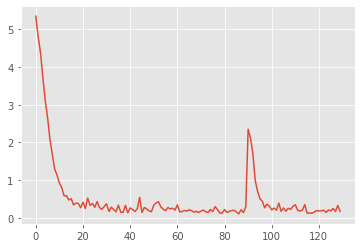

In [209]:
plt.plot(PC_losses1+PC_losses2)

In [536]:
seq = [1,2,3]
seqt = seq2onehot(seq, num_classes)
test = seqt

model.eval()
inf_iters = 200
query = 'online'
with torch.no_grad():
    online_recall = _recall(model, test, inf_iters, inf_lr, query, device)
query = 'offline'
with torch.no_grad():
    offline_recall = _recall(model, test, inf_iters, inf_lr, query, device)

norm = mpl.colors.Normalize(vmin=0, vmax=1)
fig, ax = plt.subplots(1,3)

ax[0].imshow(test.detach().numpy()[:,:num_classes], cmap='Blues', norm=norm)
ax[0].set_title('Sequence')
print(torch.argmax(test, axis=1).detach().numpy().tolist())

ax[1].imshow(online_recall.detach().numpy()[:,:num_classes], cmap='Blues', norm=norm)
print(recall2class(online_recall, num_classes,num_reps))
ax[1].set_title('Online Recall')

ax[2].imshow(offline_recall.detach().numpy()[:,:num_classes], cmap='Blues', norm=norm)
print(recall2class(offline_recall, num_classes,num_reps))
ax[2].set_title('Offline Recall')


RuntimeError: The size of tensor a (48) must match the size of tensor b (67) at non-singleton dimension 1

In [226]:
test.detach().numpy()[:,:num_classes].shape

(8, 8)

In [227]:
# online hiddens
prev_z = model.init_hidden(1).to(device)
hiddens = []
for k in range(len(test)):
    x = test[k].clone().detach()
    optimizer.zero_grad()
    model.inference(inf_iters, inf_lr, x, prev_z)
    prev_z = model.z.clone().detach()
    hiddens.append(prev_z)


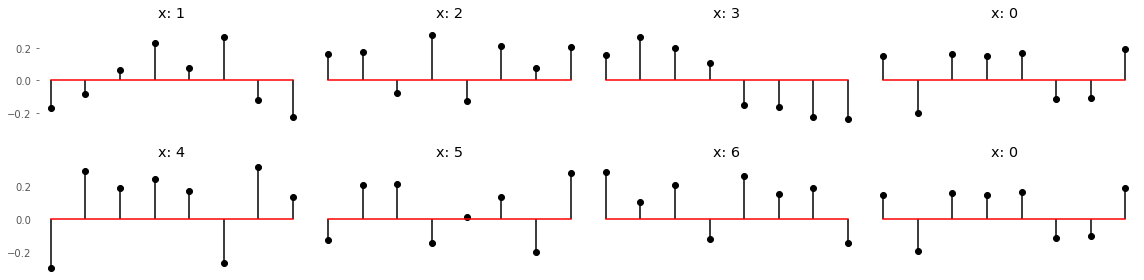

In [229]:
fig, ax = plt.subplots(2, 4, figsize=(16,4), sharey=True)
ax = ax.flatten()
for i in range(8):
    ax[i].stem(to_np(hiddens[i]).reshape(-1), linefmt='k', markerfmt='ok', basefmt = 'r')
    ax[i].set_xticks([])
    ax[i].set_frame_on(False)
    if i != 0:
        ax[i].tick_params(left=False)
    ax[i].set_title('x: ' + str(torch.argmax(test[i]).numpy()))
plt.tight_layout()
#plt.savefig(result_path + '/moving_bar_hidden.pdf')


In [493]:
## Real Data

al = pd.read_csv('results/AL_cuepops.csv', index_col=0)
inftone = pd.read_csv('results/INF_tone_cuepops.csv', index_col=0)
infled = pd.read_csv('results/INF_led_cuepops.csv', index_col=0)


In [498]:
df = al
rec_day = 5
mouse_id = 'mhb99'
md = df[(df.day == rec_day)&(df.mouse==mouse_id)].copy().reset_index()

In [499]:
inftone.columns

Index(['mouse', 'day', 'tone', 'post_tone', 'trial_type'], dtype='object')

In [500]:
idx = np.arange(md.led.shape[0]).tolist()
test_idx = random.sample(idx, int(len(idx)/4))
train_idx = [ids for ids in idx if ids not in test_idx]

train_seq = []
for dd in train_idx:
    train_seq.append(eval(md.tone[dd]))
    train_seq.append(eval(md.led[dd]))
    train_seq.append(eval(md.post_led[dd]))

train_seq = np.vstack(train_seq)
train_inputs = torch.tensor(train_seq)
    
test_seq = []
for dd in test_idx:
    al_trial = []
    al_trial.append(eval(md.tone[dd]))
    al_trial.append(eval(md.led[dd]))
    al_input = torch.tensor(np.vstack(al_trial))
    test_seq.append(al_input)


In [501]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
   
num_cues = train_inputs[0].size()[0]
seq_len = train_inputs.size()[0]
inf_iters = 5 # for this experiment inf iters too large is harmful
inf_lr = 0.01
learn_iters = 800
learn_lr = 0.01
latent_size = 8
input_size = num_cues
control_size = num_cues
sparse_penal = 0
n_cued = 1 # number of cued images
assert(n_cued < seq_len)

torch.manual_seed(1)

cpu


In [502]:
model = MultilayertPC(latent_size, input_size, nonlin='tanh').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learn_lr)
PC_losses1 = train_PC(model, optimizer, train_inputs.long(), 150, inf_iters, inf_lr, device)


Epoch 10, loss 4.801794936259586
Epoch 20, loss 3.7494388995347205
Epoch 30, loss 3.456626507971022
Epoch 40, loss 3.3369343501550186
Epoch 50, loss 3.2839640831505803
Epoch 60, loss 3.259225319933008
Epoch 70, loss 3.250653089196593
Epoch 80, loss 3.243517293974206
Epoch 90, loss 3.233385174362749
Epoch 100, loss 3.2323354195665424
Epoch 110, loss 3.2285905038868936
Epoch 120, loss 3.2320791229053785
Epoch 130, loss 3.220382306310865
Epoch 140, loss 3.217608439701574
Epoch 150, loss 3.213628239101834
training PC complete, time: 30.42985701560974


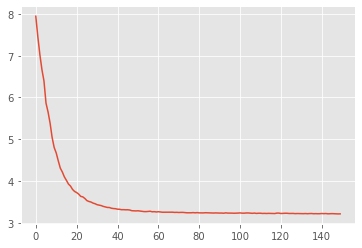

In [503]:
plt.plot(PC_losses1)

In [504]:
on_losses = []
off_losses = []
for ii in range(len(test_seq)):
    test = test_seq[ii].long()

    model.eval()
    inf_iters = 200
    query = 'online'
    with torch.no_grad():
        online_recall, online_loss = _recall(model, test, inf_iters, inf_lr, query, device)
    query = 'offline'
    with torch.no_grad():
        offline_recall, offline_loss = _recall(model, test, inf_iters, inf_lr, query, device)
        
    on_losses.append(online_loss)
    off_losses.append(offline_loss)


In [505]:
test_labs = []
for dd in test_idx:
    test_labs.append(md.trial_type[dd])


In [506]:
hiddens = []
for ii in range(len(test_seq)):
    test = test_seq[ii].long()
    prev_z = model.init_hidden(1).to(device)
    
    for k in range(len(test)):
        x = test[k].clone().detach()
        optimizer.zero_grad()
        model.inference(inf_iters, inf_lr, x, prev_z)
        prev_z = model.z.clone().detach()
        hiddens.append(prev_z.detach().numpy())

#     trial_types.append()
#     fig, ax = plt.subplots(1, 2, figsize=(16,4), sharey=True)
#     ax = ax.flatten()
#     for i in range(2):
#         ax[i].stem(to_np(hiddens[i]).reshape(-1), linefmt='k', markerfmt='ok', basefmt = 'r')
#         ax[i].set_xticks([])
#         ax[i].set_frame_on(False)
#         if i != 0:
#             ax[i].tick_params(left=False)
#         ax[i].set_title(['tone','led'][i])
#     plt.tight_layout()


In [507]:
all_hiddens = np.vstack(hiddens)

In [508]:
from sklearn.manifold import MDS 
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances

In [509]:
X = euclidean_distances(all_hiddens)

mds = MDS(dissimilarity='precomputed', random_state=0)
X_transform = mds.fit_transform(X)

/Users/miahannah/Documents/Oxford/Rotation2/HIP_V1_PCN/env/lib/python3.8/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [510]:
X_transform.shape

(12, 2)

In [511]:
markerDict = {'sucrose':'orange', 'water':'green'}

In [512]:
cols = [markerDict[tl] for tl in test_labs]
cols = list(np.repeat(cols,2))
marks = ['x','o']*6

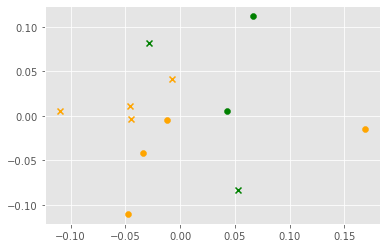

In [513]:
for ii in range(X_transform.shape[0]):
    plt.scatter(X_transform[ii,0],X_transform[ii,1], color = cols[ii], marker = marks[ii])

In [526]:
list(df.mouse.unique())

['mhb99', 'mhb100', 'mhb108', 'mhb124']

Epoch 10, loss 6.390869436716591
Epoch 20, loss 5.589870926682595
Epoch 30, loss 5.396909465875339
Epoch 40, loss 5.333970571074772
Epoch 50, loss 5.27826373655073
Epoch 60, loss 5.2542144260196775
Epoch 70, loss 5.250478053120553
Epoch 80, loss 5.22035907384836
Epoch 90, loss 5.21002041714059
Epoch 100, loss 5.207913493237424
Epoch 110, loss 5.198660427773442
Epoch 120, loss 5.185777262637945
Epoch 130, loss 5.183705659609082
Epoch 140, loss 5.180588575769906
Epoch 150, loss 5.185341172748143
training PC complete, time: 30.72316598892212
Epoch 10, loss 4.327041406046459
Epoch 20, loss 3.1395326248559816
Epoch 30, loss 2.726124958881108
Epoch 40, loss 2.557526456509044
Epoch 50, loss 2.483290158609938
Epoch 60, loss 2.457655512733456
Epoch 70, loss 2.4344801957715254
Epoch 80, loss 2.4179081524034025
Epoch 90, loss 2.4033975738523243
Epoch 100, loss 2.390539411424133
Epoch 110, loss 2.3772608260462422
Epoch 120, loss 2.3663471194487538
Epoch 130, loss 2.3581201332164246
Epoch 140, loss

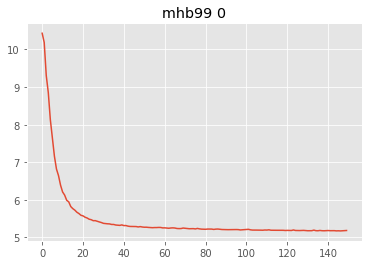

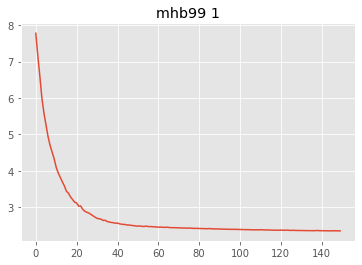

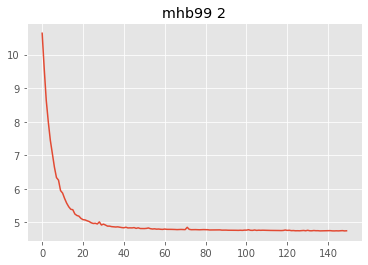

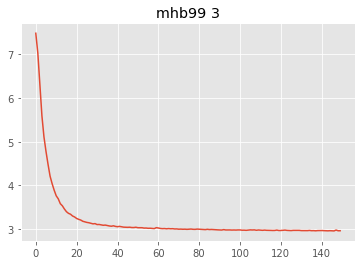

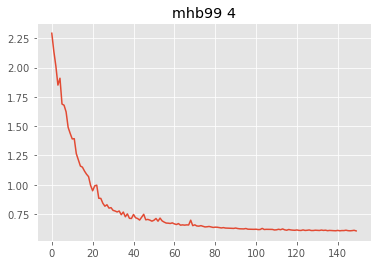

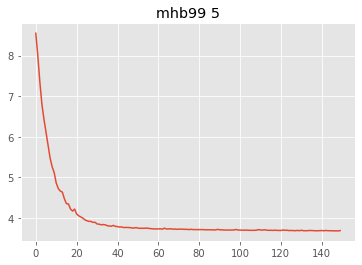

In [535]:
# Accross learning look at online accuracy
mouse_ids = list(df.mouse.unique())
 
res = {'mouse':[], 'day':[], 'type':[], 'loss':[]}
for mouse_id in ['mhb99']:
    for rec_day in range(df[df.mouse == 'mhb99'].day.max()+1):

        md = df[(df.day == rec_day)&(df.mouse==mouse_id)].copy().reset_index()

        idx = np.arange(md.led.shape[0]).tolist()
        test_idx = random.sample(idx, int(len(idx)/4))
        train_idx = [ids for ids in idx if ids not in test_idx]

        train_seq = []
        for dd in train_idx:
            train_seq.append(eval(md.tone[dd]))
            train_seq.append(eval(md.led[dd]))
            train_seq.append(eval(md.post_led[dd]))

        train_seq = np.vstack(train_seq)
        train_inputs = torch.tensor(train_seq)

        test_seq = []
        for dd in test_idx:
            al_trial = []
            al_trial.append(eval(md.tone[dd]))
            al_trial.append(eval(md.led[dd]))
            al_input = torch.tensor(np.vstack(al_trial))
            test_seq.append(al_input)
            
        num_cues = train_inputs[0].size()[0]
        seq_len = train_inputs.size()[0]
        inf_iters = 5 # for this experiment inf iters too large is harmful
        inf_lr = 0.01
        learn_iters = 800
        learn_lr = 0.01
        latent_size = 8
        input_size = num_cues
        control_size = num_cues
        sparse_penal = 0
        n_cued = 1 # number of cued images
        assert(n_cued < seq_len)
  
        model = MultilayertPC(latent_size, input_size, nonlin='tanh').to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learn_lr)

        PC_losses1 = train_PC(model, optimizer, train_inputs.long(), 150, inf_iters, inf_lr, device)
        
        plt.figure()
        plt.plot(PC_losses1)
        plt.title(mouse_id + ' ' + str(rec_day))
        
        on_losses = []
        off_losses = []
        for ii in range(len(test_seq)):
            test = test_seq[ii].long()

            model.eval()
            inf_iters = 200
            query = 'online'
            with torch.no_grad():
                online_recall, online_loss = _recall(model, test, inf_iters, inf_lr, query, device)
            query = 'offline'
            with torch.no_grad():
                offline_recall, offline_loss = _recall(model, test, inf_iters, inf_lr, query, device)

            on_losses.append(online_loss)
            off_losses.append(offline_loss)
            
            res['mouse']+= [mouse_id]*2
            res['day']+= [rec_day]*2
            res['type']+= ['online', 'offline']
            res['loss']+= [on_losses, off_losses]


losses = pd.DataFrame(res)

In [ ]:
######## Classifier

correct_choice = 'correct'
res = {'mouse':[], 'day':[],'accs':[],'acc_type':[],'layer':[]}
for rep in range(20):
    print('############ rep', rep, '  ###############')
    for mouse_id in mouse_ids:

        for rr, rec_day in enumerate(rec_days[mouse_id]):

            print(mouse_id , '  ', rec_day)
            cue_pulse_names = ['ledsucrose','ledwater']
            sess_type = 'rl'
            cue_pops = get_layer_cuepop(mouse_id, rec_day, cue_pulse_names, sess_type, correct_trials= correct_choice)
            
            sess_type = 'tt'
            cue_pulse_names = ['toneSucrose','toneWater']
            cue_pop_tts = get_layer_cuepop(mouse_id, rec_day, cue_pulse_names, sess_type, correct_trials= correct_choice)
            cue_pop_tt_shifts = get_layer_cuepop(mouse_id, rec_day, cue_pulse_names, sess_type, shift = True, correct_trials= correct_choice)

            if cue_pops == None:
                print('empty cue_pop')
                continue

            ## sample same number of cells from each layer
            select_cells = np.min([np.sum(led_cells_inf['L23'][mouse_id][rec_day]) ,np.sum(led_cells_inf['L56'][mouse_id][rec_day])])
            for layer, layer_name in enumerate(['L23', 'L56']):

                cue_pop = cue_pops[layer]
                cue_pop_tt = cue_pop_tts[layer]
                cue_pop_tt_shift = cue_pop_tt_shifts[layer]
                
                
                tcells = led_cells_inf[layer_name][mouse_id][rec_day].reshape(-1)
                for cue in cue_pop:
                    cue_pop[cue] = cue_pop[cue][:, tcells]
                for cue in cue_pop_tt:
                    cue_pop_tt[cue] = cue_pop_tt[cue][:, tcells]
                    cue_pop_tt_shift[cue] = cue_pop_tt_shift[cue][:, tcells]
                
                if cue_pop['ledsucrose'].shape[1] != select_cells:

                    select_idx = random.sample(range(cue_pop['ledsucrose'].shape[1]),select_cells)
                    select_idx.sort()
                    for cue in cue_pop:
                        cue_pop[cue] = cue_pop[cue][:, select_idx]
                    for cue in cue_pop_tt:
                        cue_pop_tt[cue] = cue_pop_tt[cue][:, select_idx]
                        cue_pop_tt_shift[cue] = cue_pop_tt_shift[cue][:, select_idx]
                
                print(layer, '  ', cue_pop['ledsucrose'].shape)

                X, Y, Y_string = extract_XY(cue_pop)
                X_t1, Y_t1, Y_string_t1 = extract_XY(cue_pop_tt)
                X_t2, Y_t2, Y_string_t2 = extract_XY(cue_pop_tt_shift)

                unique, counts = np.unique(Y, return_counts = True)
                uniquet, countst = np.unique(Y_t1, return_counts = True)
                if (len(unique)<2) or (min(counts)<2) or (X.shape[1] < 1) or (len(uniquet)<2) or (min(countst)<2):
                    do_clf=0
                    print('skipped : ', mouse_id, '  ', rec_day)
                else:
                    do_clf=1

                if do_clf:

                    cv = RepeatedStratifiedKFold(n_splits=np.min(counts),n_repeats=10)
                
                    # scale and transform
                    scaling = StandardScaler()
                    scaling.fit(X)

                    # Transform training and test
                    X_t1_scaled = scaling.transform(X_t1)
                    X_t2_scaled = scaling.transform(X_t2)

                    model =  LogisticRegression(penalty='l1',solver='liblinear',random_state=0).fit(X,Y)
                    score1 = balanced_accuracy_score(Y_t1, model.predict(X_t1_scaled), adjusted=True)
                    score2 = balanced_accuracy_score(Y_t2, model.predict(X_t2_scaled), adjusted=True)
                    res['accs'] += [score1, score2]
                    res['acc_type'] += ['t1', 't2']
                    res['mouse']+= [mouse_id]*2
                    res['day']+= [rr]*2
                    res['layer']+= [layer_name]*2

df_inf_tone = pd.DataFrame(res)
inf_tone = df_inf_tone.groupby(['mouse', 'day', 'acc_type','layer']).agg({'accs':'mean'}).reset_index()